In [44]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [45]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

In [46]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    """
    计算k近邻图

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - k: 最近邻的数量

    Returns:
    - knn_adjacency_matrix: k近邻图的邻接矩阵，W[i, j]表示样本点i和j之间是否相连
    """
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        np.savetxt('knn_adjacency_matrix.csv', knn_adjacency_matrix, delimiter = ',')
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            distances = np.sqrt(np.sum((Data[i] - Data) ** 2, axis=1))
            neighbors = []
            for j in range(n):  # 初始化 neighbors 列表
                if (distances[j] <= radius[i]) and (len(neighbors) <= n/2): # 如果样本点 j 在第i个样本点的epsilon邻域内
                    neighbors.append(j)
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    if method == 'knn':
        # 计算相似度矩阵
        similarity_matrix = np.exp(-distances ** 2 / t)
        # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
        i_indices, j_indices = np.where(adjacency_matrix == 1)
        # 设置权重
        Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
        Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / t) # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / t) # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    print('adjacency_matrix:', adjacency_matrix.shape)
    print('Weight_matrix:', Weight_matrix.shape)
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix               

In [47]:
def LPP(Data, method, d, k, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - d: 降维后的维度
    - k: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    """
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [48]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
'''
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")
'''

'\n# 绘制三维数据集\nfig = plt.figure(figsize=(14,10))\nax = fig.add_subplot(111, projection="3d")\nax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)\nax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))\nax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))\nax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))\nplt.title(\'Data - \'+ str(Data.shape[1]) + \' points\', size=30)\nax.axis("off")\n'

adjacency_matrix: (1000, 1000)
Weight_matrix: (1000, 1000)


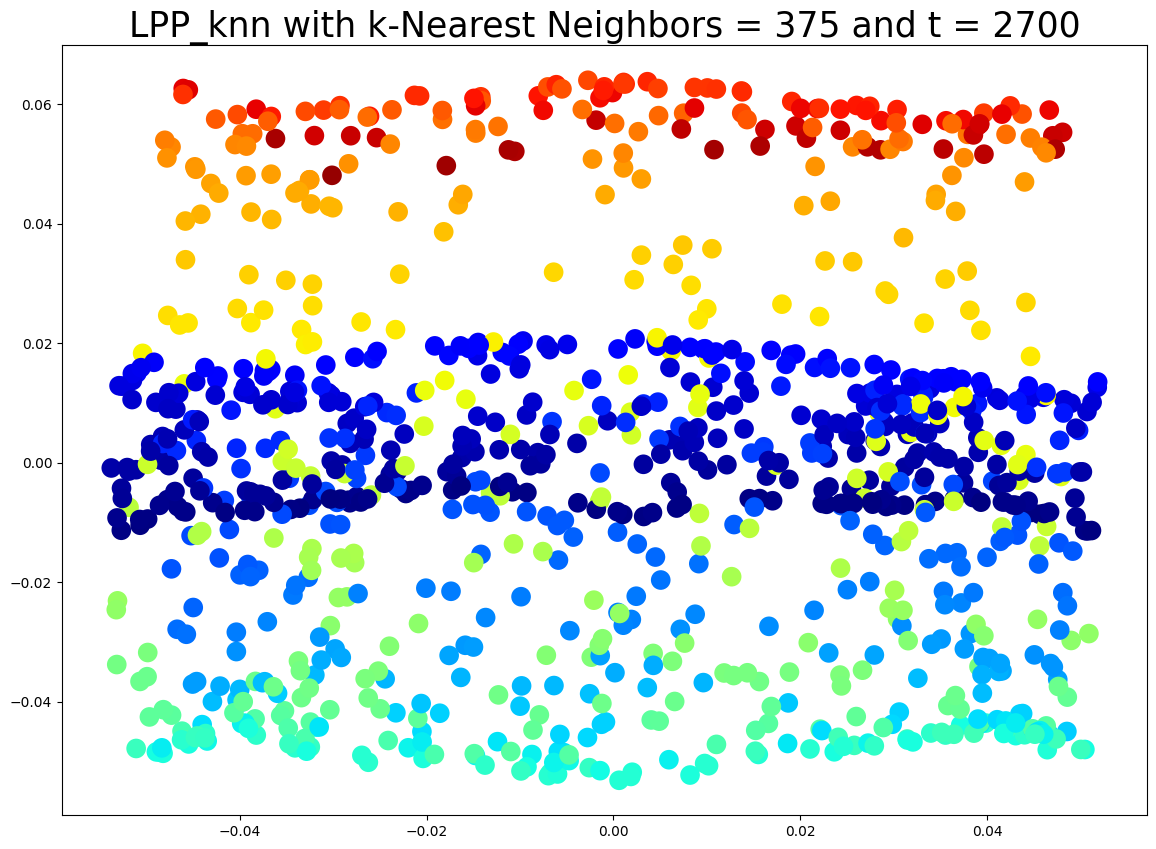

adjacency_matrix: (1000, 1000)
Weight_matrix: (1000, 1000)


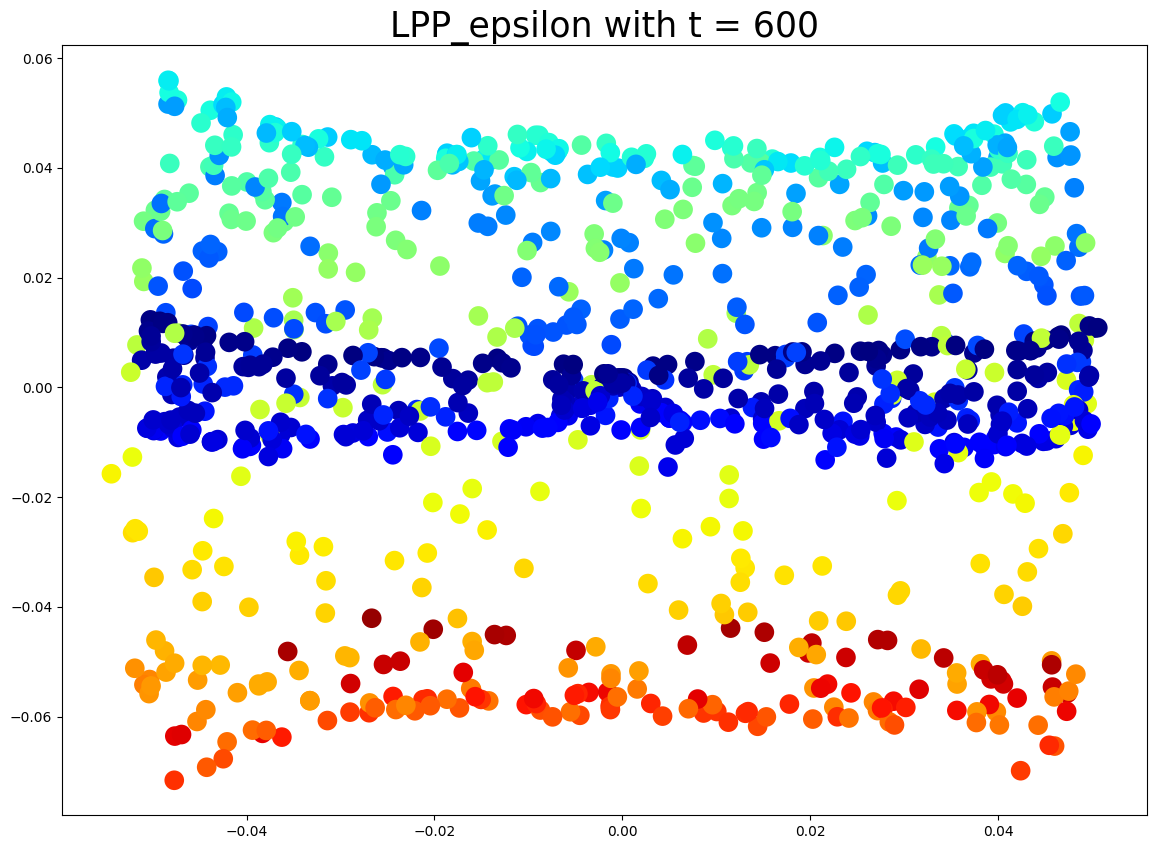

In [49]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['knn', 'epsilon']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 600
        lpp_embeddings = LPP(Data_T, d=2, method=method, k=375, t=t)
        plt.title('LPP_epsilon with t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        k = 375
        t= 2700
        lpp_embeddings = LPP(Data_T, d=2, method=method, k=k, t=t)
        plt.title('LPP_knn with k-Nearest Neighbors = ' + str(k) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(k) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()

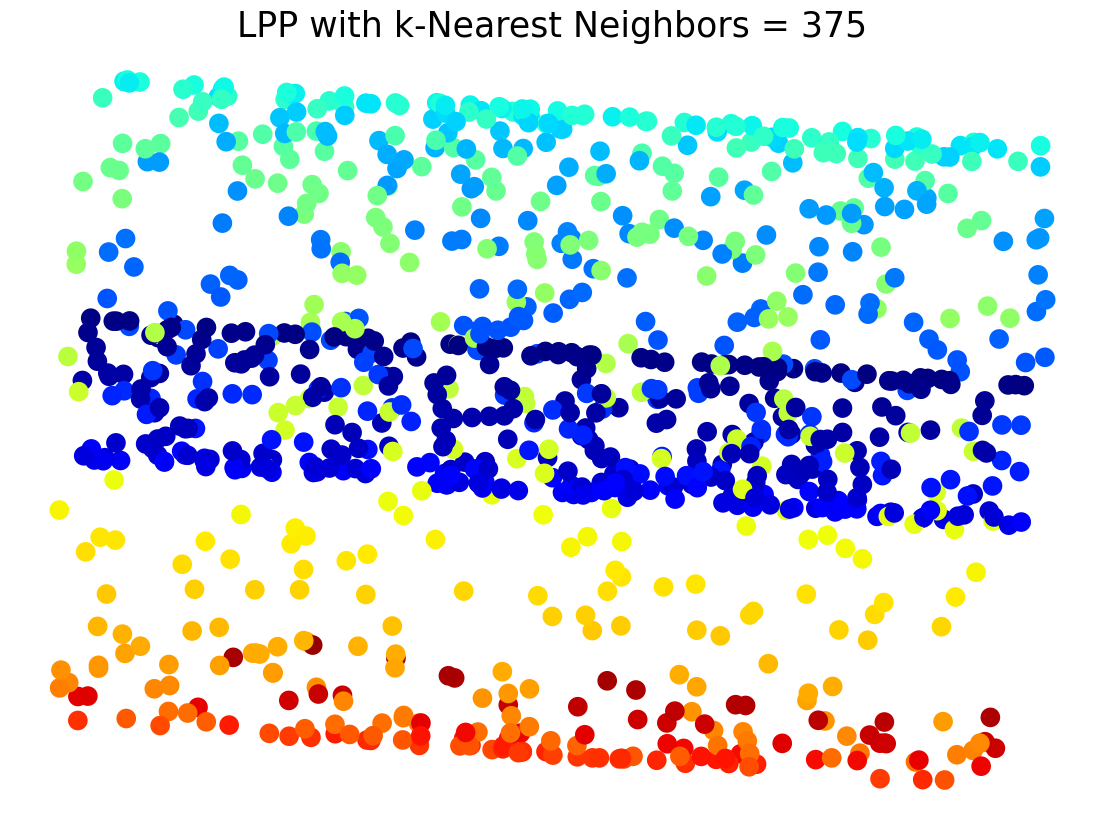

In [50]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=k, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(k), size=25)
plt.axis("off")
plt.show()